In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Read GNN train and test prc value CSVs

In [2]:
train_prcs = pd.read_csv('processed-data/train_prc_values.csv', sep='\t')
train_prcs.drop(columns=['Unnamed: 0'], inplace=True)
train_prcs.head()

,file_name,precision,recall,thresholds,average_precision
0,vitamin_b6_metabolis_train_1175.csv,[0. 0. 0. ... 0. 0. 1.],[1. 1. 1. ... 1. 1. 0.],[0.04978353 0.0500779 0.05021047 ... 0.158941...,-0.0
1,vitamin_b6_metabolis_train_3756.csv,[9.89653176e-06 9.89662970e-06 9.89667867e-06 ...,[1. 1. 1. ... 1. 1. 0.],[0.01461539 0.01468741 0.01469137 ... 0.991771...,1.0
2,vitamin_b6_metabolis_train_3761.csv,[0. 0. 0. ... 0. 0. 1.],[1. 1. 1. ... 1. 1. 0.],[0.04978353 0.0500779 0.05021047 ... 0.158941...,-0.0
3,vitamin_b6_metabolis_train_6075.csv,[0. 0. 0. ... 0. 0. 1.],[1. 1. 1. ... 1. 1. 0.],[0.04978353 0.0500779 0.05021047 ... 0.158941...,-0.0
4,vitamin_b6_metabolis_train_7692.csv,[0. 0. 0. ... 0. 0. 1.],[1. 1. 1. ... 1. 1. 0.],[0.04978353 0.0500779 0.05021047 ... 0.158941...,-0.0


In [3]:
test_prcs = pd.read_csv('processed-data/test_prc_values.csv', sep='\t')
test_prcs.drop(columns=['Unnamed: 0'], inplace=True)
test_prcs.head()

,file_name,precision,recall,thresholds,average_precision
0,vitamin_b6_metabolis_train_6881.csv,[9.89658073e-06 9.89662970e-06 9.89667867e-06 ...,[1. 1. 1. ... 1. 0.5 0. ],[0.01374454 0.01381178 0.01381377 ... 0.999007...,1.00000
1,"valine,_leucine_and__train_1863.csv",[4.94829037e-06 4.94831485e-06 4.94833934e-06 ...,[1. 1. 1. ... 1. 0. 0.],[0.01404285 0.01406828 0.0140906 ... 0.999492...,0.50000
2,"valine,_leucine_and__train_7368.csv",[4.94829037e-06 4.94831485e-06 4.94833934e-06 ...,[1. 1. 1. ... 1. 0. 0.],[0.01404285 0.01406828 0.01409061 ... 0.999492...,0.50000
3,"valine,_leucine_and__(1)_train_4437.csv",[6.43277748e-05 6.43280931e-05 6.43284114e-05 ...,[1. 1. 1. ... 0.076923...,[0.01489307 0.01489419 0.01494932 ... 0.999975...,0.60632
4,ubiquinone_and_other_train_2517.csv,[1.48448711e-05 1.48449446e-05 1.48450180e-05 ...,[1. 1. 1. ... 0.666666...,[0.01819973 0.01837175 0.02080133 ... 0.999831...,1.00000


In [4]:
train_prcs['prefix'] = train_prcs['file_name'].str.extract(r'^(.*)_train_\d+\.csv$')
test_prcs['prefix'] = test_prcs['file_name'].str.extract(r'^(.*)_train_\d+\.csv$')

#### Read Oi2 prc value CSVs

In [5]:
oi2_prc_df = pd.read_csv('processed-data/oi2_summary_ap_scores.csv', sep='\t')
oi2_prc_df.head()

,Sample,AveragePrecision
0,alanine__a_1510,0.016665
1,alanine__a_2535,0.023841
2,alanine__a_3273,0.020378
3,alanine__a_3711,0.027565
4,alanine__a_3781,0.005766


In [6]:
oi2_prc_df['prefix'] = oi2_prc_df['Sample'].str[:10]
# grouped_oi2_prc_df = oi2_prc_df.groupby('prefix')

#### Build box plots

In [7]:
# tag each source
d_gnn = test_prcs.assign(source='gnn')
d_oi2 = oi2_prc_df.assign(source='oi2')

In [8]:
# stack them into one “long” DataFrame
long = pd.concat([d_gnn, d_oi2], ignore_index=True)

In [9]:
# x-axis order. Here we take all prefixes in sorted order:
order = sorted(long['prefix'].unique())

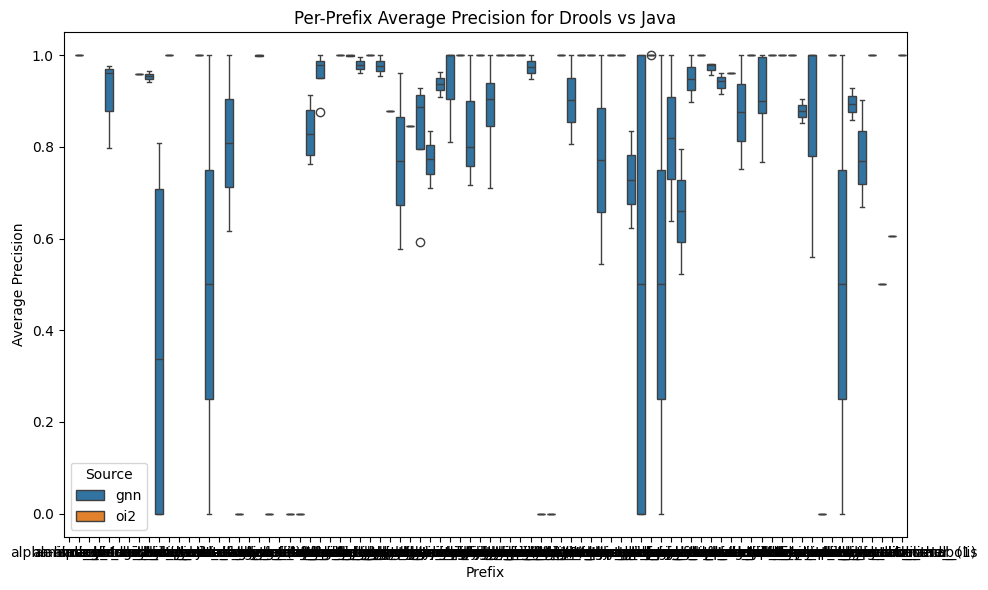

In [10]:
# 3) draw the boxplot
plt.figure(figsize=(10,6))
sns.boxplot(
    data=long,
    x='prefix',
    y='average_precision',
    hue='source',
    order=order,
    palette={'oi2':'#FF7F0E','gnn':'#1F77B4'}
)
plt.xlabel("Prefix")
plt.ylabel("Average Precision")
plt.title("Per-Prefix Average Precision for Drools vs Java")
plt.legend(title="Source")
plt.tight_layout()
plt.show()